In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [3]:
os.listdir('./')

['.DS_Store',
 'kaggle.ipynb',
 'test.csv',
 'porto-seguro-safe-driver-prediction',
 'train.csv',
 '.ipynb_checkpoints',
 'sample_submission.csv']

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [6]:
print(train.shape, test.shape)

(595212, 59) (892816, 58)


In [7]:
# 중복 행 확인
train.drop_duplicates()
train.shape

(595212, 59)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [9]:
# 데이터 유형은 정수형 or 실수형
# 현재 null 값은 -1로 대체 됨

In [10]:
data = []
for f in train.columns:
    # role 정의
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        
    if 'bin' in f or f == 'target':
        level = 'binary'           # binary = 이중분류
    elif 'cat' in f or f == 'id':
        level = 'nominal'           # nominal 범주간 숫자는 이름의 역할일뿐 (categorical)
    elif train[f].dtype == float:
        level = 'interval'           # ex)온도 / 키 이런게 아님 / 절대 0과 비율은 의미가 없음
    elif train[f].dtype == int:
        level = 'ordinal'           # 범주간 이름의 역할 뿐만 아니라 순위가 있다. (categorical)
        
    keep = True
    if f == 'id':
        keep = False  # id일때 false
        
    dtype = train[f].dtype
    
    f_dict = {
        'varname': f,
        'role' : role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
meta = pd.DataFrame(data, columns = f_dict.keys())
meta.set_index('varname', inplace = True)

In [11]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [12]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['level'].size()})

count
role   level          
id     nominal       1
input  binary       17
       interval     10
       nominal      14
       ordinal      16
target binary        1

In [13]:
# interval 변수

interval_col = meta[(meta.level == 'interval') & (meta.keep)].index

train[interval_col].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [14]:
# reg 변수
# ps_reg_03 변수만 누락 값이 존재 / 변수들 마다 범위(최소-최대)는 다름
# 스케일링은 할 수 있지민 우리가 사용하려는 분류기마다 다를 것

# car 변수 
# ps_car_12와 ps_car_15는 누락 값이 존재
# 변수들마다 범위가 다르고 스케일링 할 수 있다.

# calc 변수
# 누락값 없음
# 최대가 0.9로 동일 / 어떤 비율일 것
# 3개의 calc 변수가 모두 유사한 분포를 가짐

In [15]:
#Ordinal 변수

ordinal_col = meta[(meta.level == 'ordinal') & (meta.keep)].index

train[ordinal_col].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [16]:
# ps_car_11 만 유일하게 누락값이 존재
# 다양한 범위를 다루기 위해 스케일링 적용 가능

In [17]:
# Binary 변수
binary_col = meta[(meta.level == 'binary') & (meta.keep)].index
train[binary_col].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# 0.03645로 train 데이터의 선험을 매우 불균형하다.
# 평균을 통해 대부분의 경우 값이 0이라고 알 수 있다.

In [19]:
# 불균형 클래스 다루기
# target = 0인 레코드의 비율이 훨씬 많다.
# target = 1 레코드를 오버샘플링 or target = 0 레코드를 언더샘플링
# 커다란 훈련 세트가 있으니 언더샘플링

In [20]:
desired_apriori = 0.10

idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

undersampling_rate = (((1-desired_apriori)*nb_1) / (nb_0*desired_apriori))
undersampled_nb_0 = int(undersampling_rate*nb_0)

In [21]:
print(undersampled_nb_0,nb_0, nb_1)

195246 573518 21694


In [22]:
from sklearn.utils import shuffle
undersampled_idx = shuffle(idx_0, random_state=121, n_samples = undersampled_nb_0)
idx_list = list(undersampled_idx) + list(idx_1)
# idx_list
# undersampled_idx

In [23]:
train = train.loc[idx_list].reset_index(drop=True)
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,338314,0,3,1,4,1,0,0,0,0,...,13,1,5,8,1,0,1,1,1,0
1,1355175,0,3,1,6,0,0,1,0,0,...,1,2,1,5,0,0,1,1,0,0
2,1209401,0,0,1,2,1,0,1,0,0,...,1,1,2,7,1,1,1,1,0,0
3,407879,0,0,1,8,0,0,1,0,0,...,9,1,3,5,0,0,0,1,0,0
4,647950,0,1,1,3,0,0,1,0,0,...,3,1,7,7,0,1,1,0,1,0


In [24]:
print(train.shape)
train['target'].value_counts()

(216940, 59)


0    195246
1     21694
Name: target, dtype: int64

In [25]:
vars_with_missing = []

for f in train.columns:
  missings = train[train[f] == -1][f].count()
  if missings > 0:
    vars_with_missing.append(f)
    missings_perc = missings / train.shape[0]
    
    print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))    

Variable ps_ind_02_cat has 100 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2315 records (1.07%) with missing values
Variable ps_reg_03 has 38617 records (17.80%) with missing values
Variable ps_car_01_cat has 60 records (0.03%) with missing values
Variable ps_car_02_cat has 1 records (0.00%) with missing values
Variable ps_car_03_cat has 148856 records (68.62%) with missing values
Variable ps_car_05_cat has 96288 records (44.38%) with missing values
Variable ps_car_07_cat has 4483 records (2.07%) with missing values
Variable ps_car_09_cat has 217 records (0.10%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15567 records (7.18%) with missing values
In total, there are 12 variables with missing values


In [26]:
# 누락 된 값이 너무 많은 변수는 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # 메타 데이터 갱신

# 평균 또는 모드로 대체하기
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

In [27]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [28]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing은 Daniele Micci-Barreca의 논문에서와 같이 계산됩니다.
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : pd.Series 형태의 학습할 범주형 피처
    tst_series : pd.Series 형태의 테스트할 범주형 피처
    target : pd.Series 형태의 타겟 데이터
    min_samples_leaf (int) : 범주의 평균을 고려할 최소 샘플
    smoothing (int) : 범주 평균과 이전의 균형을 맞추기 위한 스무딩 효과 
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # 타겟 평균을 계산
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # 스무딩 계산
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # 모든 타겟 데이터에 평균 적용하기
    prior = target.mean()
    # 카운트가 클수록 full_avg가 적어집니다.
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # 학습, 테스트 데이터에 평균 적용
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [29]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

<Figure size 432x288 with 0 Axes>

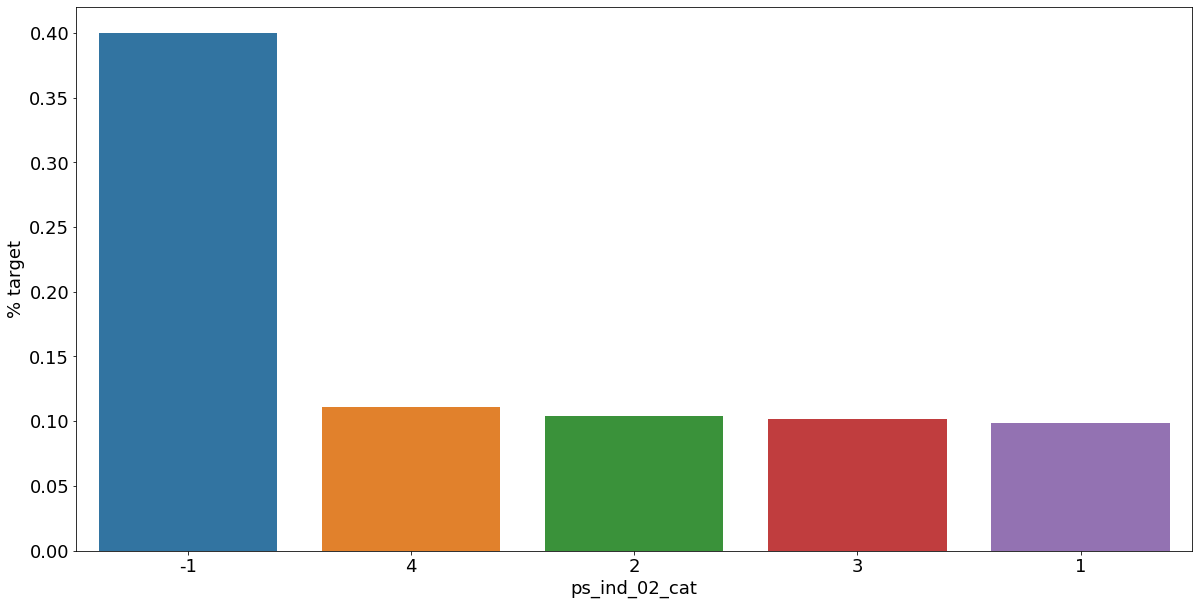

<Figure size 432x288 with 0 Axes>

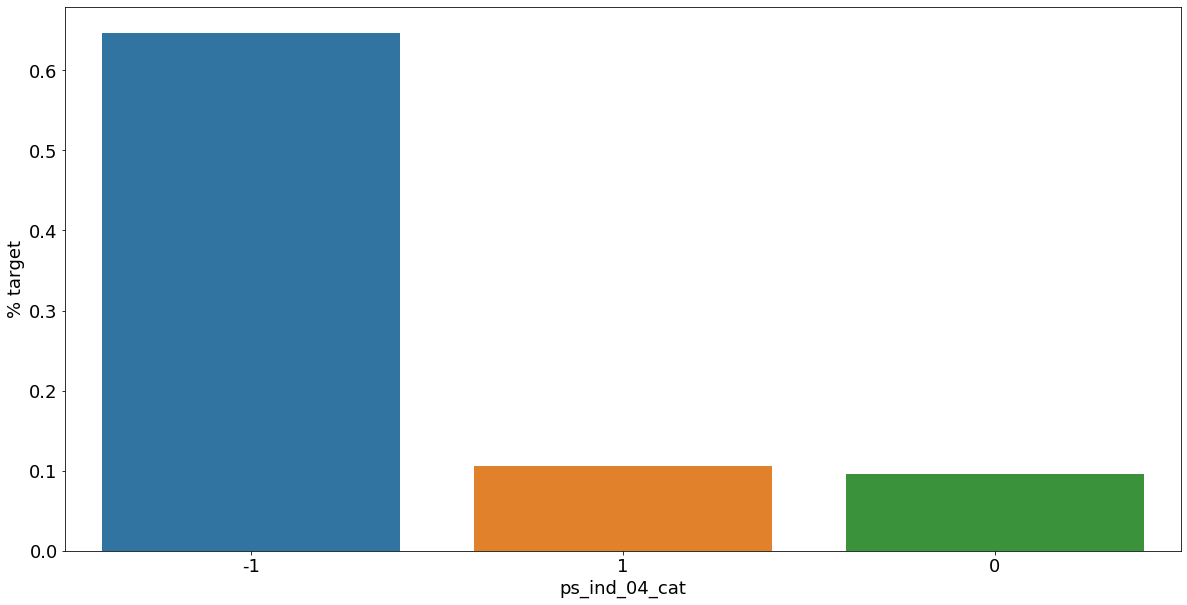

<Figure size 432x288 with 0 Axes>

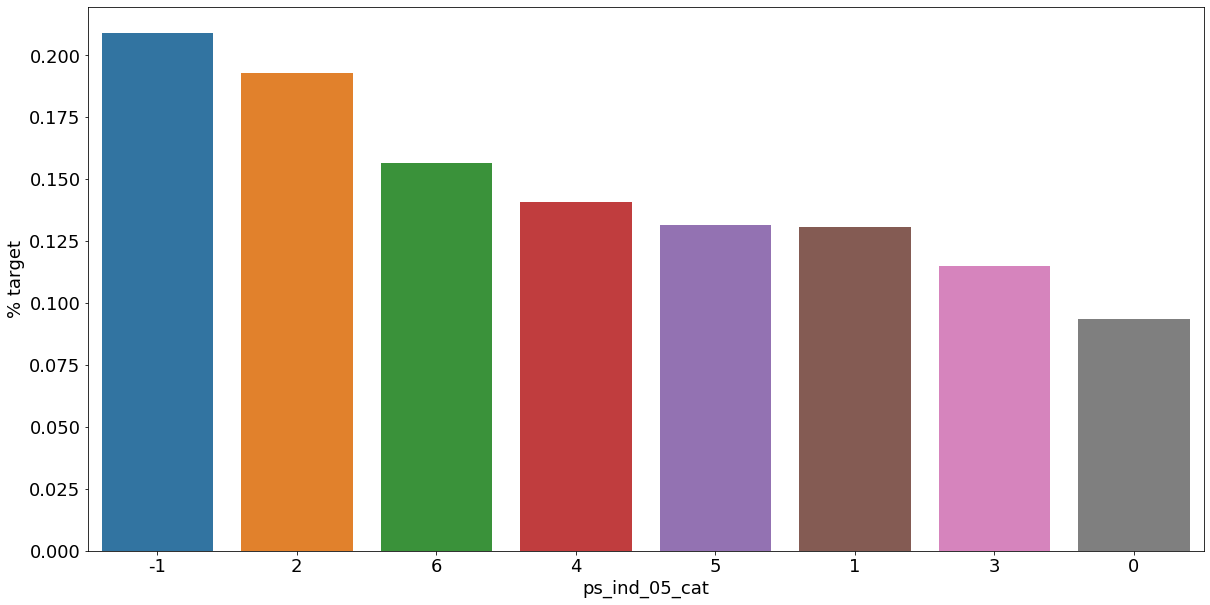

<Figure size 432x288 with 0 Axes>

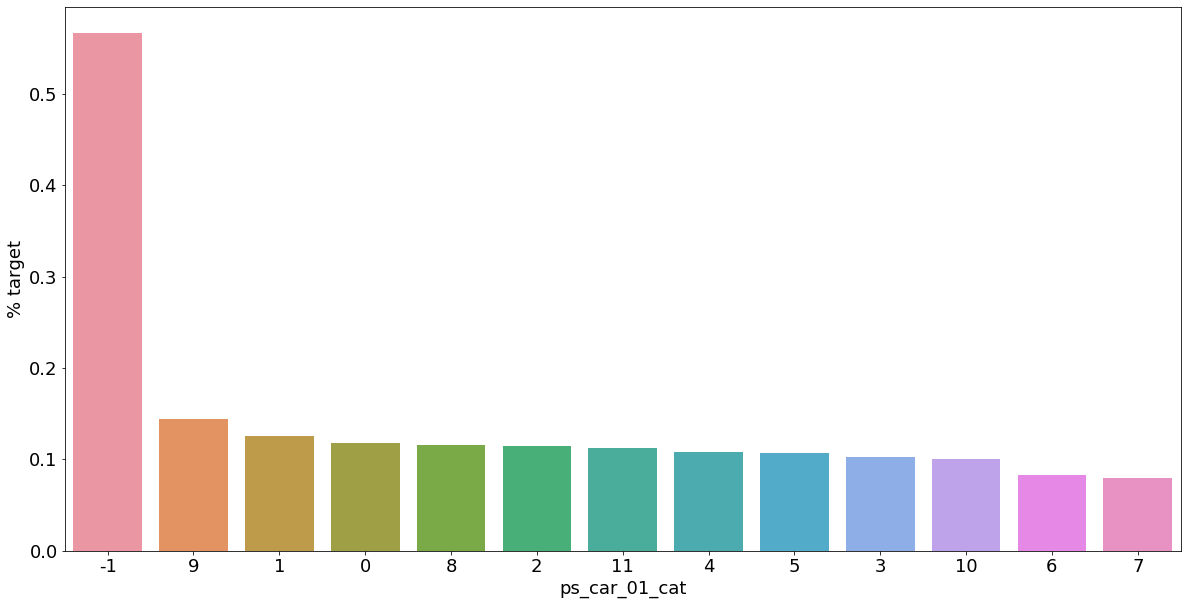

<Figure size 432x288 with 0 Axes>

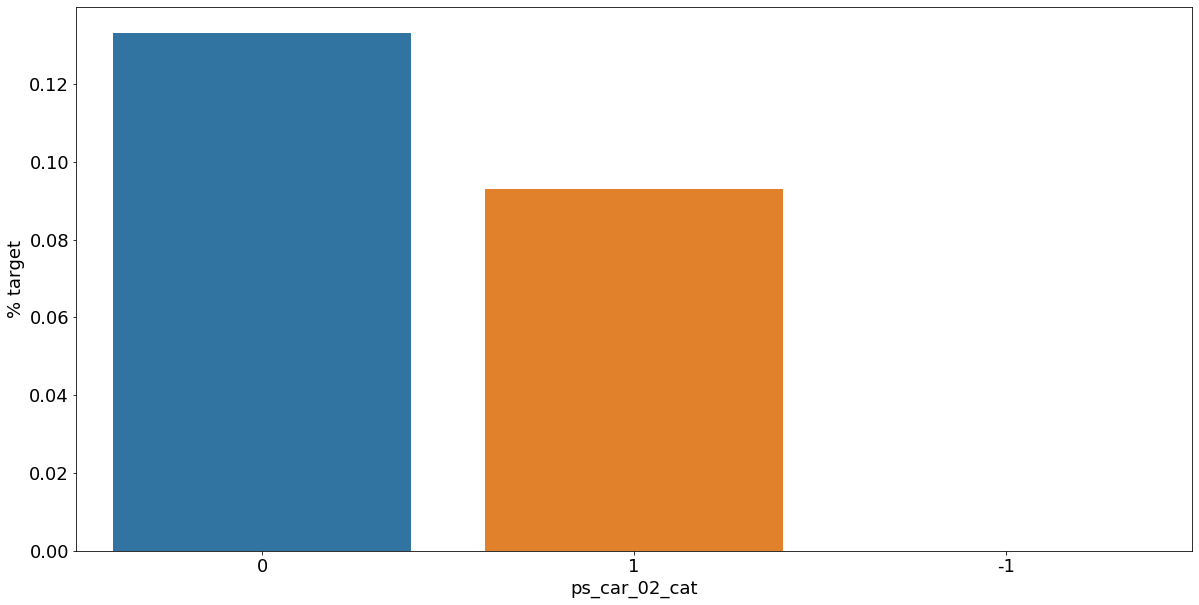

<Figure size 432x288 with 0 Axes>

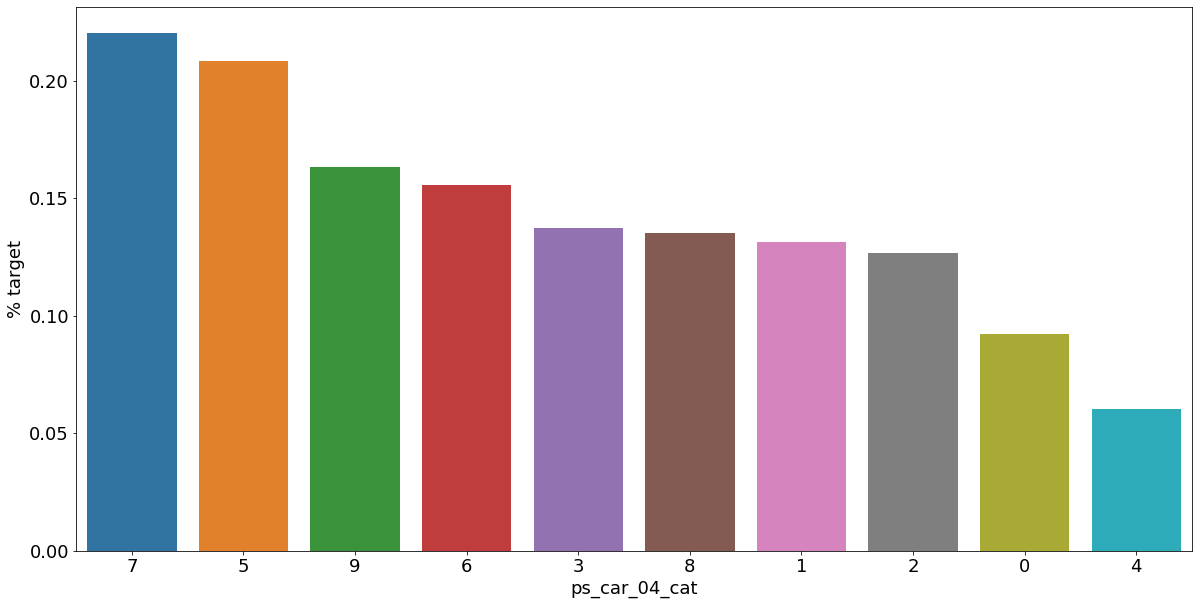

<Figure size 432x288 with 0 Axes>

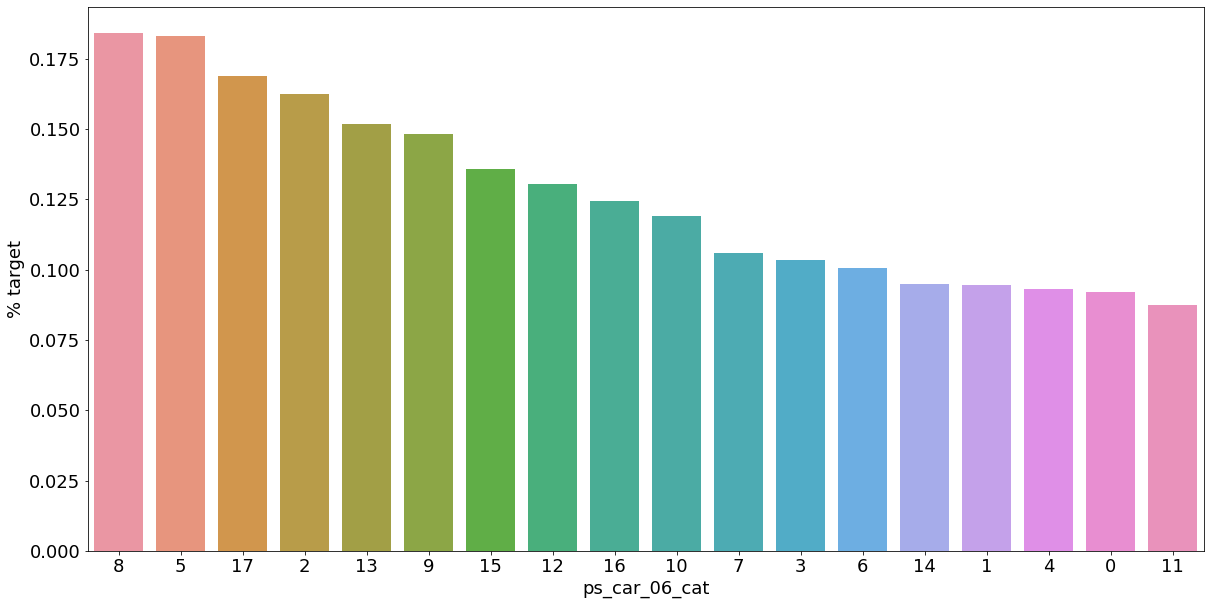

<Figure size 432x288 with 0 Axes>

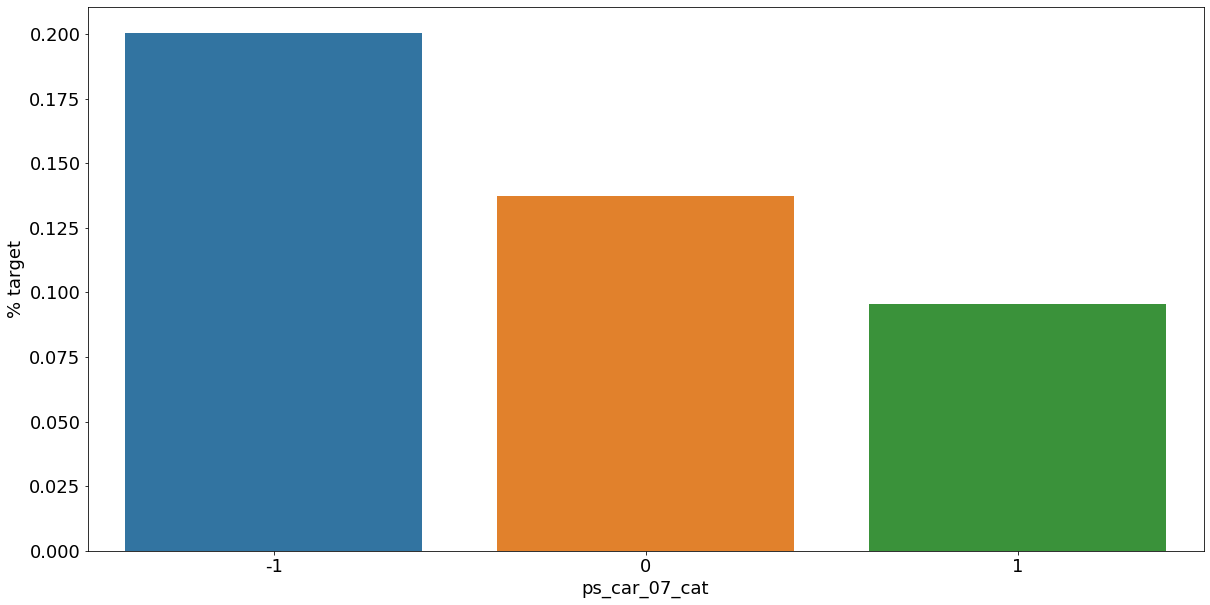

<Figure size 432x288 with 0 Axes>

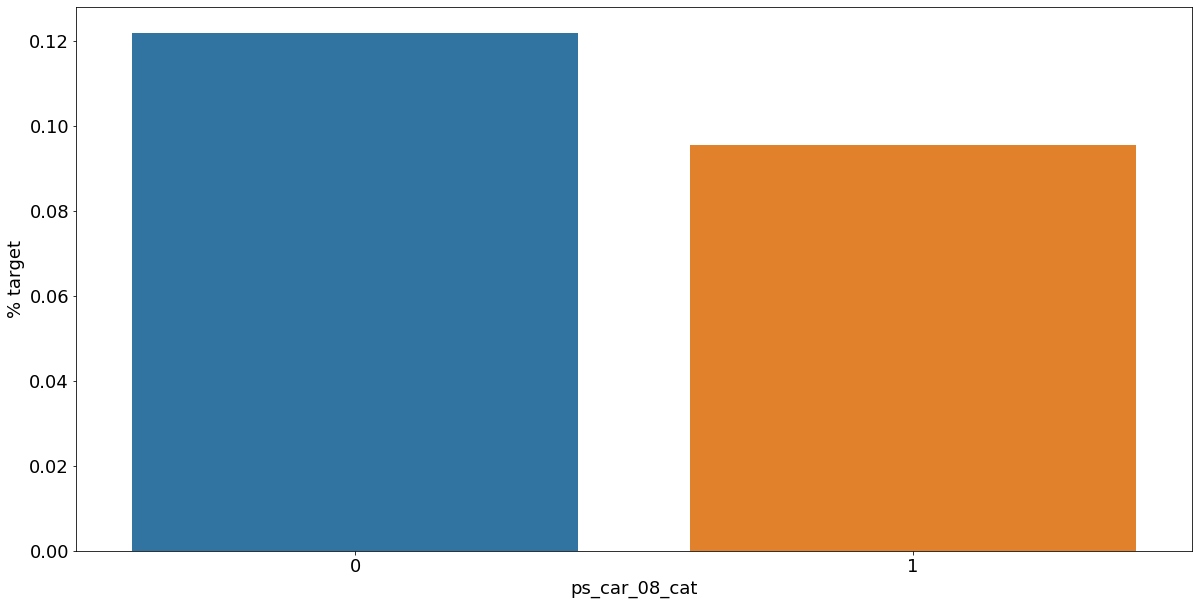

<Figure size 432x288 with 0 Axes>

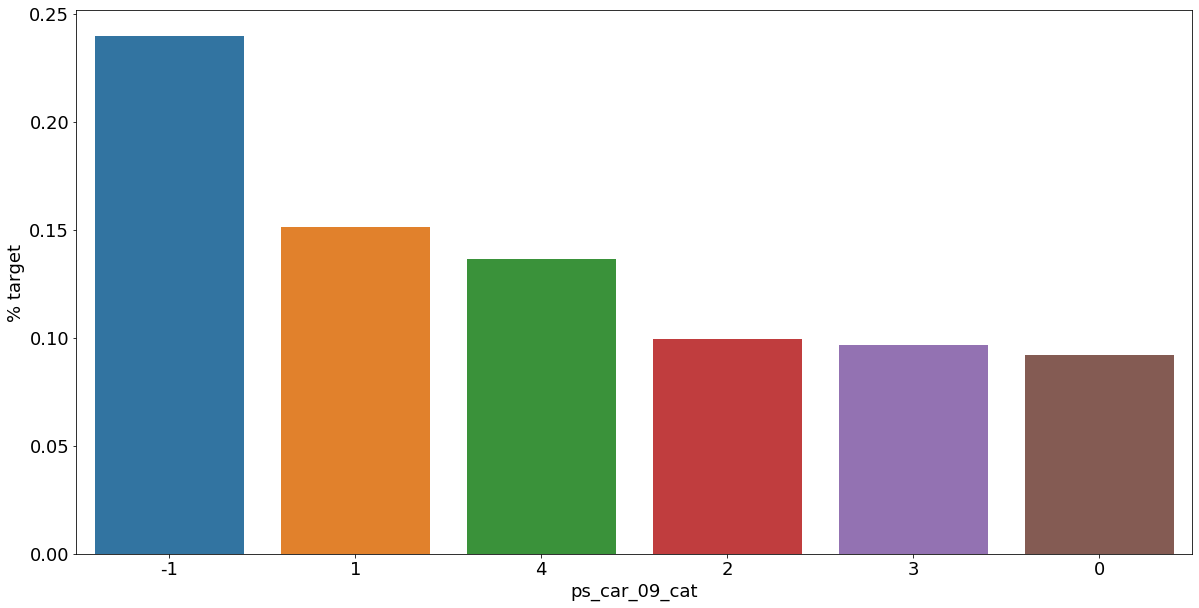

<Figure size 432x288 with 0 Axes>

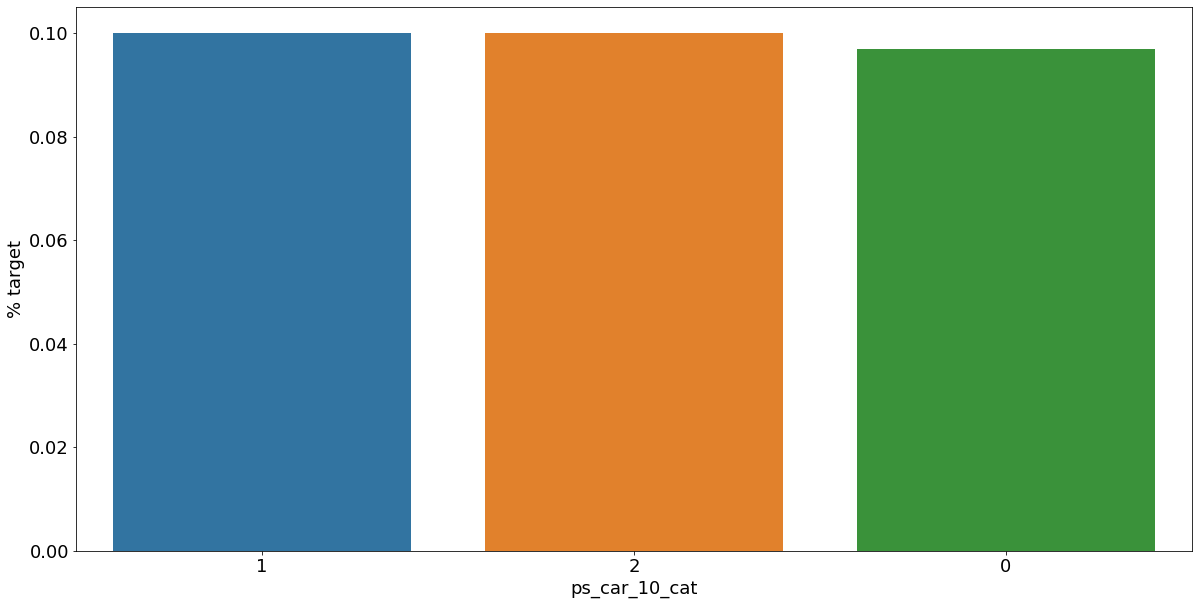

In [30]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # 범주형 값 당 타겟값이 1인 퍼센트를 계산
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar 플롯
    # 타겟 평균으로 내림차순
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

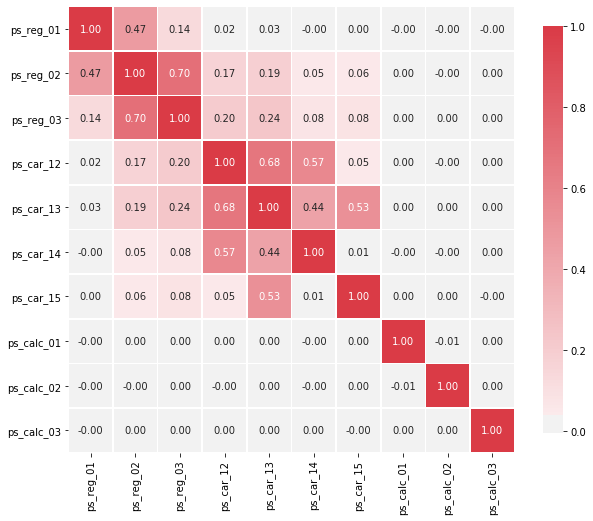

In [31]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # 두 가지 색상 사이의 색상 맵 만들기
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

In [32]:
s = train.sample(frac=0.1)

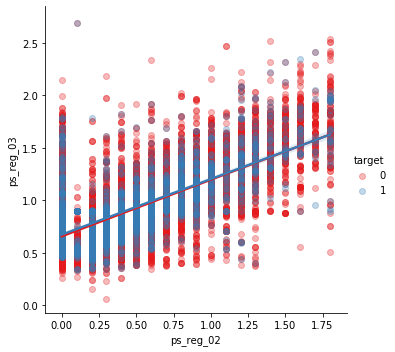

In [33]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

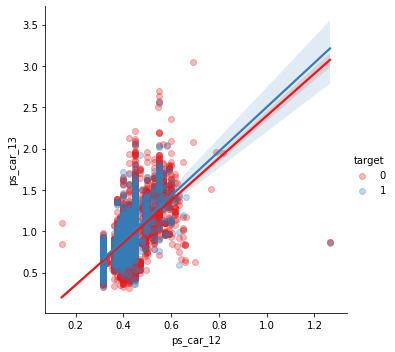

In [34]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

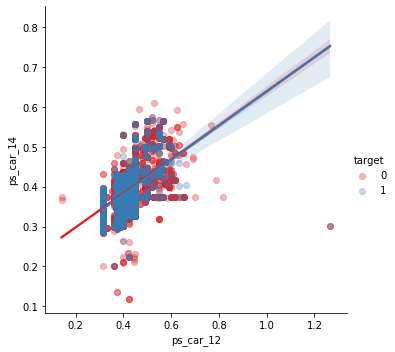

In [35]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

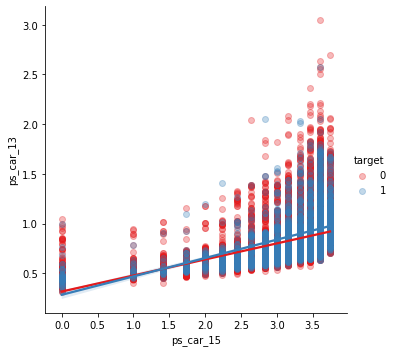

In [36]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

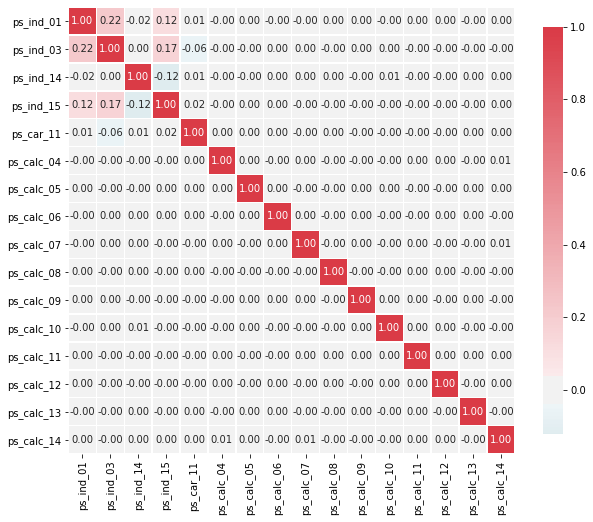

In [37]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

In [38]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 109 variables in train


In [39]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # 원래의 컬럼 제거
# train 데이터에 상호 작용 변수 연결
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


In [40]:
train.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,...,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,338314,0,3,4,0,0,0,1,0,0,...,12.0,2.078461,3.117691,2.078461,0.36,0.54,0.36,0.81,0.54,0.36
1,1355175,0,3,6,1,0,0,0,0,0,...,11.0,0.994987,2.653300,1.326650,0.09,0.24,0.12,0.64,0.32,0.16
2,1209401,0,0,2,1,0,0,0,0,0,...,14.0,0.374166,3.367492,2.619160,0.01,0.09,0.07,0.81,0.63,0.49
3,407879,0,0,8,1,0,0,0,0,0,...,12.0,2.078461,1.732051,2.424871,0.36,0.30,0.42,0.25,0.35,0.49
4,647950,0,1,3,1,0,0,0,0,0,...,7.0,0.000000,0.529150,2.116601,0.00,0.00,0.00,0.04,0.16,0.64


In [41]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # id와 target 변수 없이 훈련하는 것이 적합하다.
f = np.vectorize(lambda x : not x) # 부울 배열 요소를 토글하는 함수
v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


In [42]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.021044
 2) ps_car_13^2                    0.017354
 3) ps_car_13                      0.017339
 4) ps_car_12 ps_car_13            0.017260
 5) ps_reg_03 ps_car_13            0.017146
 6) ps_car_13 ps_car_14            0.017114
 7) ps_reg_01 ps_car_13            0.016823
 8) ps_car_13 ps_car_15            0.016684
 9) ps_reg_03 ps_car_14            0.016276
10) ps_reg_03 ps_car_12            0.015608
11) ps_reg_03 ps_car_15            0.015190
12) ps_car_14 ps_car_15            0.014920
13) ps_car_13 ps_calc_01           0.014724
14) ps_reg_01 ps_reg_03            0.014719
15) ps_car_13 ps_calc_03           0.014683
16) ps_car_13 ps_calc_02           0.014682
17) ps_reg_02 ps_car_13            0.014680
18) ps_reg_01 ps_car_14            0.014392
19) ps_reg_03                      0.014257
20) ps_reg_03^2                    0.014198
21) ps_reg_03 ps_calc_02           0.013780
22) ps_reg_03 ps_calc_03           0.013755
23) ps_car_14 ps_calc_02        

In [43]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [44]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.94162968,  0.54717412, -0.15682001, ...,  1.95517655,
         1.6760397 ,  0.27696829],
       [ 1.42592651,  0.54717412,  0.58211423, ...,  1.32176527,
         0.58141138, -0.46674883],
       [ 1.08652109, -0.9624845 , -0.89575425, ...,  1.95517655,
         2.12384219,  0.76038443],
       ...,
       [ 1.73452155, -0.9624845 ,  0.58211423, ..., -0.4666901 ,
         0.18336472,  0.27696829],
       [ 1.73459606, -0.9624845 , -0.89575425, ..., -0.91380395,
        -0.41370528,  0.27696829],
       [ 1.7348708 , -0.45926496, -1.26522137, ...,  0.27849964,
        -0.11517028, -0.72704983]])

In [45]:
MAX_ROUNDS = 400
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 50  

In [46]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
# import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
import warnings
warnings.filterwarnings("ignore")

In [47]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [48]:
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]


def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))
  
def target_encode(trn_series=None,  
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing은 Daniele Micci-Barreca의 논문에서와 같이 계산됩니다.
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : pd.Series 형태의 학습할 범주형 피처
    tst_series : pd.Series 형태의 테스트할 범주형 피처
    target : pd.Series 형태의 타겟 데이터
    min_samples_leaf (int) : 범주의 평균을 고려할 최소 샘플
    smoothing (int) : 범주 평균과 이전의 균형을 맞추기 위한 스무딩 효과 
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [49]:
# 데이터 읽기
train_df = pd.read_csv("./train.csv", na_values="-1")
test_df = pd.read_csv("./test.csv", na_values="-1")

In [50]:
# olivier 커널 참고
train_features = [
  "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
]
# 조합 추가
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

In [51]:
# 데이터 처리
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]

current feature                                 ps_reg_01_plus_ps_car_04_cat    2 in   0.0

In [52]:
y_valid_pred = 0*y
y_test_pred = 0

In [53]:
# 폴드 설정
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

In [54]:
## 분류기 설정
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )



In [55]:
# CV 실행
for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    
    # 폴드에 대한 데이터 생성
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
    
    # 데이터 인코드
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
    # 폴드에 대한 모델 실행
    if OPTIMIZE_ROUNDS:
        eval_set=[(X_valid,y_valid)]
        fit_model = model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric=gini_xgb,
                               early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                               verbose=False
                             )
        print( "  Best N trees = ", model.best_ntree_limit )
        print( "  Best gini = ", model.best_score )
    else:
        fit_model = model.fit( X_train, y_train )
        
    # 폴드에 대한 검증 예측 생성
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # 테스트 세트의 예측을 누적
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # 테스트 세트 예측의 평균

print( "\nGini for full training set:" )
eval_gini(y, y_valid_pred)


Fold  0
  Gini =  0.28641695259346556

Fold  1
  Gini =  0.2819388953345532

Fold  2
  Gini =  0.2737455287867744

Fold  3
  Gini =  0.3011534034783515

Fold  4
  Gini =  0.28440374572271565

Gini for full training set:


0.2852862571573006

In [60]:
# 스태킹 / 앙상블을위한 검증 예측 저장
val = pd.DataFrame()
val['id'] = id_train
val['target'] = y_valid_pred.values
val.to_csv('./xgb_valid.csv', float_format='%.6f', index=False)

In [61]:
## 제출 파일 생성
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_test_pred
sub.to_csv('./xgb_submit.csv', float_format='%.6f', index=False)